In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder
import sklearn.metrics

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [2]:
folder_dir = '../data/'
data_path = "data_clean.csv"
data = pd.read_csv(filepath_or_buffer= folder_dir + data_path, header=0)
data=data.drop('Unnamed: 0',axis=1)

#=data.head(500)

In [3]:
data.shape

(3878118, 25)

In [35]:
data.isnull().any()[data.isnull().any()]

outcome    True
nasty      True
dtype: bool

In [4]:
### Create features
data.columns

Index(['date', 'umpcall', 'outcome', 'start_speed', 'pfx_x', 'pfx_z', 'px',
       'pz', 'break_y', 'break_angle', 'break_length', 'pitch_type',
       'spin_dir', 'nasty', 'pitch_count', 'descr', 'y', 'year', 'zone',
       'strikes', 'balls', 'pitcher', 'pitch_type.1', 'rolling_start_speed',
       'long_rolling_start_speed'],
      dtype='object')

## Train, test, validation split

In [5]:
model_feats=['px','pz','pfx_x','pfx_z','start_speed','spin_dir','pitch_count','balls','strikes','date',
             'y','rolling_start_speed']

model_feats=['px','pz','pfx_x','pfx_z','start_speed','spin_dir','pitch_count','balls','strikes','date',
             'y','rolling_start_speed','long_rolling_start_speed']
#y=data['y']
data=data[model_feats]

In [6]:
data["date"] = pd.to_datetime(data["date"])

start = data["date"].searchsorted(datetime.datetime(2012, 1, 1))[0]
#start
end = data["date"].searchsorted(datetime.datetime(2017, 1, 1))[0] - 1
#end

X_train = data[model_feats].loc[start:end]
y_train=X_train['y']
X_train=X_train.drop(['y','date'],axis=1)

X_test=data[model_feats][end:]
y_test=X_test['y']
X_test=X_test.drop(['y','date'],axis=1)
data=0

### Random Forest

In [39]:
steps= [('rf', RandomForestClassifier(oob_score=True))]

mypipeline= Pipeline(steps)

param_grid_rf = dict(
    #rf__min_samples_leaf= np.logspace(4, 5, num=5, base=4, endpoint=False, dtype=int),
    #rf__min_samples_split= [100, 1000],
    rf__max_depth= [7],
    rf__n_estimators=[50]
      )

In [40]:
rf_grid_search= GridSearchCV(mypipeline, 
                             param_grid = param_grid_rf, 
                             scoring = 'neg_log_loss',
                                    n_jobs=-1, refit=True)

rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'rf__max_depth': [7], 'rf__n_estimators': [50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [41]:
best_1 = rf_grid_search.best_score_
print(best_1)
rf_grid_search.best_estimator_
model=rf_grid_search.best_estimator_.steps[0][1]
print(model)

-0.520574641936
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


In [42]:
probs=model.predict_proba(X_test)[:,1]
preds=model.predict(X_test)
baseline_loss=sklearn.metrics.log_loss(y_test,probs)
baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
majority_class=np.amax(y_test.value_counts(normalize=True))

print('%s: %0.2f, %s: %0.2f, %s: %0.2f '
      %('Model accuracy',baseline_acc,'Model log loss', baseline_loss,'Majority class',majority_class))

Model accuracy: 0.78, Model log loss: 0.51, Majority class: 0.56 


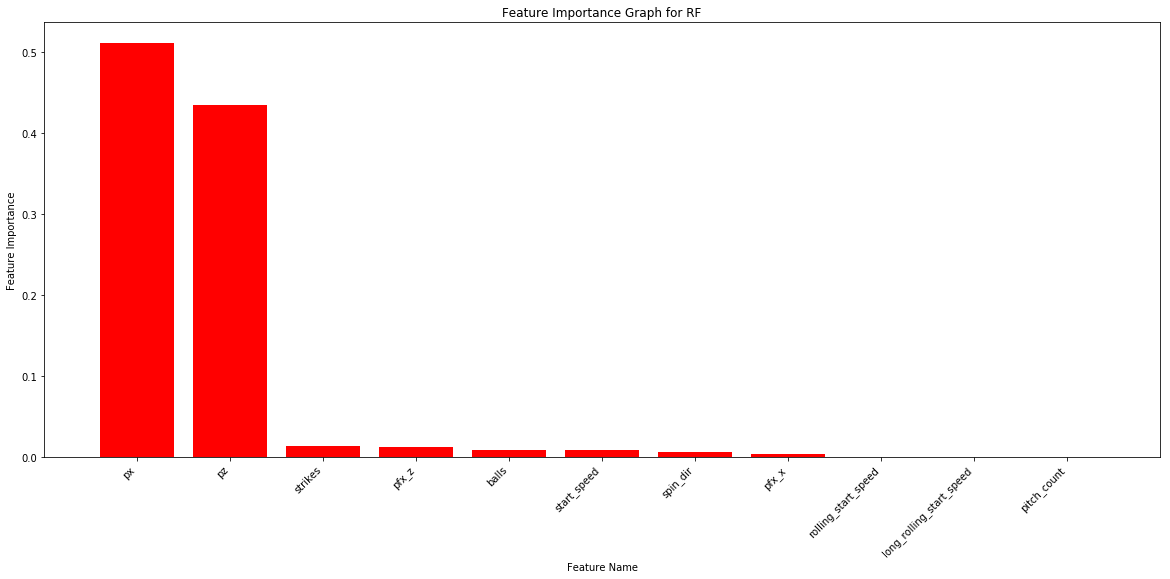

In [43]:
# RF Feature Importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig = plt.figure(figsize=(20,8))
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.title('Feature Importances Bar Plot')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=45, horizontalalignment='right')
plt.xlim([-1, len(indices)])
plt.title('Feature Importance Graph for RF')
plt.show()

In [44]:
STOP=

SyntaxError: invalid syntax (<ipython-input-44-e26cd6df4ee3>, line 1)

In [ ]:
#Get class probabilities
#probabilities_rf = model.predict_proba(X_test)
#print('\rSaving class probabilities.', end='\r')
#np.savetxt(folder_dir + 'probabilities_rf.txt', probabilities_rf, delimiter=',', newline='\n')

## Logistic Regression

In [ ]:
#Create pipeline
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)
steps= [('polyfeat', PolynomialFeatures()),
         ('scaler', StandardScaler()),
         ('lr', LogisticRegression())]

mypipeline= Pipeline(steps)
parameters = dict(lr__C = [10**i for i in range(-5, 5)],
                  lr__penalty = ['l1', 'l2'])

In [ ]:
lr_grid_search= GridSearchCV(mypipeline, 
                             param_grid = parameters,  
                             scoring = 'log_loss',
                             n_jobs=-1, 
                             refit=True,
                             cv = my_cv)

lr_grid_search.fit(X_train, y_train)

In [ ]:
best_1 = lr_grid_search.best_score_
print(best_1)
lr_grid_search.best_estimator_
model=lr_grid_search.best_estimator_.steps[2][1]
print(model)

In [ ]:
model=lr_grid_search.best_estimator_.steps[2][1]

In [ ]:
probs=model.predict_proba(X_test)[:,1]
preds=model.predict(X_test)
baseline_loss=sklearn.metrics.log_loss(y_test,probs)
baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
majority_class=np.amax(y_test.value_counts(normalize=True))

print('%s: %0.2f, %s: %0.2f, %s: %0.2f '
      %('Model accuracy',baseline_acc,'Model log loss', baseline_loss,'Majority class',majority_class))

In [ ]:
probabilities_lr=model.predict_proba(X_test)[:,1]
np.savetxt'probabilities_lr.txt', probabilities_lr, delimiter=',', newline='\n')

In [ ]:
coef_dict = {}
for coef, feat in zip(model.coef_[0],X_train.columns.tolist()):
    coef_dict[feat] = coef
coef_dict

In [ ]:
stop=

## XGBoost

/Users/atakanokan/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.782464286982


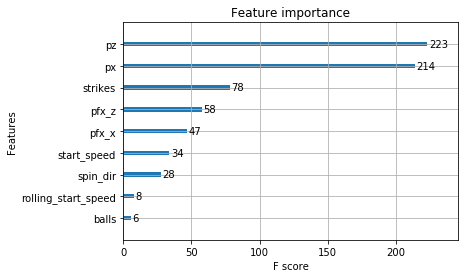

In [10]:
from numpy import loadtxt
from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# fit model no training data
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
model = XGBClassifier()
model.fit(X_train, y_train)

# evaluate predictions
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
xgb_acc=sklearn.metrics.accuracy_score(y_test,predictions)

print(xgb_acc)

import xgboost
xgboost.plot_importance(model)

In [13]:
param = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch1 = GridSearchCV(estimator = model, 
                        param_grid = param, 
                        scoring='roc_auc',
                        #n_jobs=4,
                        iid=False, 
                        cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, 

/Users/atakanokan/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.84156, std: 0.00153, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.84168, std: 0.00142, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.84159, std: 0.00146, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.84437, std: 0.00147, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.84428, std: 0.00145, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.84433, std: 0.00145, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.84569, std: 0.00159, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.84574, std: 0.00149, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.84565, std: 0.00145, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 6, 'min_child_weight': 5},
 0.84573547851392805)

In [14]:
print("Best parameters = " + str(gsearch1.best_params_))
print("Best score = " + str(gsearch1.best_score_))

Best parameters = {'max_depth': 6, 'min_child_weight': 5}
Best score = 0.845735478514


In [18]:
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)

In [19]:
param = {
 'max_depth':[4,6],
 'min_child_weight':[4,6]
}

gsearch1 = GridSearchCV(estimator = model, 
                        param_grid = param, 
                        scoring='neg_log_loss',
                        #n_jobs=4,
                        iid=False, 
                        cv=my_cv)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_

/Users/atakanokan/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.47473, std: 0.00270, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -0.47477, std: 0.00258, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.46871, std: 0.00194, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -0.46848, std: 0.00203, params: {'max_depth': 6, 'min_child_weight': 6}],)

In [20]:
print("Best parameters = " + str(gsearch1.best_params_))
print("Best score = " + str(gsearch1.best_score_))

Best parameters = {'max_depth': 6, 'min_child_weight': 6}
Best score = -0.468475527781


In [27]:
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)

param = {
 'max_depth':[4,6],
 'min_child_weight':[4,6]
}

gsearch2 = GridSearchCV(estimator = model, 
                        param_grid = param, 
                        scoring='neg_log_loss',
                        #n_jobs=4,
                        iid=False, 
                        cv=my_cv)
gsearch2.fit(X_train,y_train)
gsearch2.grid_scores_ 

print("Best parameters = " + str(gsearch2.best_params_))
print("Best score = " + str(gsearch2.best_score_))

Best parameters = {'max_depth': 6, 'min_child_weight': 6}
Best score = -0.468475527781


/Users/atakanokan/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [29]:
gsearch2.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=6, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [31]:
model=gsearch2.best_estimator_
print(model)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=6, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [32]:
probs=model.predict_proba(X_test)[:,1]
preds=model.predict(X_test)
baseline_loss=sklearn.metrics.log_loss(y_test,probs)
baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
majority_class=np.amax(y_test.value_counts(normalize=True))

print('%s: %0.2f, %s: %0.2f, %s: %0.2f '
      %('Model accuracy',baseline_acc,'Model log loss', baseline_loss,
        'Majority class',majority_class))

Model accuracy: 0.79, Model log loss: 0.47, Majority class: 0.56 


In [28]:
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)

param = {
 'max_depth':[2,5,8],
 'min_child_weight':[2,4,6]
}

gsearch3 = GridSearchCV(estimator = model, 
                        param_grid = param, 
                        scoring='neg_log_loss',
                        #n_jobs=4,
                        iid=False, 
                        cv=my_cv)
gsearch3.fit(X_train,y_train)
gsearch3.grid_scores_ 

print("Best parameters = " + str(gsearch3.best_params_))
print("Best score = " + str(gsearch3.best_score_))

Best parameters = {'max_depth': 8, 'min_child_weight': 6}
Best score = -0.466955890944


/Users/atakanokan/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [33]:
model=gsearch3.best_estimator_
print(model)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=6, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [34]:
probs=model.predict_proba(X_test)[:,1]
preds=model.predict(X_test)
baseline_loss=sklearn.metrics.log_loss(y_test,probs)
baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
majority_class=np.amax(y_test.value_counts(normalize=True))

print('%s: %0.2f, %s: %0.2f, %s: %0.2f '
      %('Model accuracy',baseline_acc,'Model log loss', baseline_loss,
        'Majority class',majority_class))

Model accuracy: 0.79, Model log loss: 0.47, Majority class: 0.56 
